In [1]:
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from numpy import array , hstack

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

import os
print(os.getcwd())

# fix random seed for reproducibility
from numpy.random import seed
seed(1)

data = pd.read_excel('/content/data.xlsx')
data


/content


,Date,Mean_areal_rainfall_upper,Inflow
0,2000-06-01,1.896728,39.6763
1,2000-06-02,1.223008,0.0000
2,2000-06-03,2.578513,0.0000
3,2000-06-04,1.107180,0.0000
4,2000-06-05,1.633354,0.0000
...,...,...,...
1825,2014-09-26,0.031930,2117.0600
1826,2014-09-27,0.000000,1921.1200
1827,2014-09-28,0.000000,1807.4700
1828,2014-09-29,0.306218,1421.1800


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from numpy import array, hstack

# Load the data
data = pd.read_excel('/content/data.xlsx')

# Convert 'Date' column to datetime and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split into train and validation based on date
data_train = data.loc[:'2010-09-30', :]

# Smoothing the data using Hamming window
for i in range(data_train.shape[1]):
    closes = data_train.iloc[:, i].values
    N = 20  # Blackman window size
    window = np.hamming(N)
    smoothed = np.convolve(window / window.sum(), closes, mode='same')
    data_train.iloc[:, i] = smoothed

# Normalizing the data with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_stacked = np.empty((len(data_train), 0))

for column in data_train.columns:
    x = data_train[column].values.reshape((-1, 1))  # Reshape for scaler
    x = scaler.fit_transform(x)  # Normalize
    dataset_stacked = hstack((dataset_stacked, x))  # Stack normalized columns

print("dataset_stacked.shape:", dataset_stacked.shape)

# Function to split the multivariate sequence into input-output samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences) - n_steps_out):
        # Find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # Check if we are beyond the dataset
        if out_end_ix > len(sequences) - n_steps_out:
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix + 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Define the number of time steps
n_steps_in, n_steps_out = 30, 8

# Convert into input-output sequences
X, y = split_sequences(dataset_stacked, n_steps_in, n_steps_out)
print("X.shape:", X.shape)  # Should be (samples, n_steps_in, features)
print("y.shape:", y.shape)  # Should be (samples, n_steps_out)

# Splitting the dataset into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)



dataset_stacked.shape: (1342, 2)
X.shape: (1298, 30, 2)
y.shape: (1298, 8)


In [3]:
# Dataset and DataLoader
from torch.utils.data import DataLoader, TensorDataset

# Convert train and validation data to PyTorch tensors
train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
val_X_tensor = torch.tensor(val_X, dtype=torch.float32)
val_y_tensor = torch.tensor(val_y, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
val_dataset = TensorDataset(val_X_tensor, val_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=18, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=18, shuffle=False)

In [4]:
'''import torch
import torch.nn as nn

# Define the T2V Layer
class T2V(nn.Module):
    def __init__(self, output_dim):
        super(T2V, self).__init__()
        self.output_dim = output_dim
        self.W = None
        self.P = None
        self.w = None
        self.p = None

    def build(self, input_shape):
        # Dynamically initialize weights based on the input shape
        _, seq_len, input_dim = input_shape  # Extract sequence length and input dimension
        self.W = nn.Parameter(torch.empty((input_dim, self.output_dim)))
        self.P = nn.Parameter(torch.empty((seq_len, self.output_dim)))
        self.w = nn.Parameter(torch.empty((seq_len, 1)))
        self.p = nn.Parameter(torch.empty((seq_len, 1)))

        # Uniform initialization for weights
        nn.init.uniform_(self.W)
        nn.init.uniform_(self.P)
        nn.init.uniform_(self.w)
        nn.init.uniform_(self.p)

    def forward(self, x):
        if self.W is None:  # Build weights dynamically on the first forward pass
            self.build(x.shape)

        # Perform the T2V transformation
        original = self.w * x + self.p
        sin_trans = torch.sin(torch.matmul(x, self.W) + self.P)

        # Concatenate the results along the last dimension
        output = torch.cat((sin_trans, original), dim=-1)
        return output


# Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
     def __init__(self, d_model, nhead, d_ff, dropout=0.0,bias=False):
        super().__init__()
        self.d_model=d_model
        self.nhead=nhead
        self.d_ff = d_ff
        self.attn = MultiHeadAttention(d_model, nhead,dropout,bias)
        self.ff = FeedForward(d_model, d_ff, dropout)
        #Layer Normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        #Dropouts
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    def forward(self, x):
        # Self-attention + Add & Norm
        x2 = self.norm1(x + self.dropout1(self.attn(x, x, x)))
        # Feed-forward + Add & Norm
        x3 = self.norm2(x2 + self.dropout2(self.ff(x2)))
        return x3

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim=159, d_model=64, t2v_output_dim=64, nhead=4, ff_dim=128, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()
        # Initialize T2V Layer
        self.t2v_layer = T2V(t2v_output_dim)

        # Input Linear Projection
        input_size = input_dim + t2v_output_dim
        self.encoder = nn.Linear(input_size, d_model)

        # Transformer Encoder Blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderBlock(head_size=d_model // nhead, num_heads=nhead, ff_dim=ff_dim,
                                    input_dim=d_model, dropout=dropout)
            for _ in range(num_layers)
        ])

        # Final Decoder
        self.decoder = nn.Linear(d_model, 5)

    def forward(self,x):

        # Pass through T2V layer
        x = self.t2v_layer(x)

        # Linear encoding
        x = self.encoder(x)

        # Transformer Encoder Blocks
        for block in self.transformer_blocks:
            x = block(x)

        # Final Decoder: Take the output of the last timestep
        x = self.decoder(x[:, -1, :])
        return x
'''



'import torch\nimport torch.nn as nn\n\n# Define the T2V Layer\nclass T2V(nn.Module):\n    def __init__(self, output_dim):\n        super(T2V, self).__init__()\n        self.output_dim = output_dim\n        self.W = None\n        self.P = None\n        self.w = None\n        self.p = None\n\n    def build(self, input_shape):\n        # Dynamically initialize weights based on the input shape\n        _, seq_len, input_dim = input_shape  # Extract sequence length and input dimension\n        self.W = nn.Parameter(torch.empty((input_dim, self.output_dim)))\n        self.P = nn.Parameter(torch.empty((seq_len, self.output_dim)))\n        self.w = nn.Parameter(torch.empty((seq_len, 1)))\n        self.p = nn.Parameter(torch.empty((seq_len, 1)))\n\n        # Uniform initialization for weights\n        nn.init.uniform_(self.W)\n        nn.init.uniform_(self.P)\n        nn.init.uniform_(self.w)\n        nn.init.uniform_(self.p)\n\n    def forward(self, x):\n        if self.W is None:  # Build we

In [5]:
import torch
import torch.nn as nn

# Dummy MultiHeadAttention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.0, bias=False):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout, bias=bias, batch_first=True)
    def forward(self, x, key, value):
        out, _ = self.attn(x, key, value)
        return out

# Dummy FeedForward
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.0):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
    def forward(self, x):
        return self.ff(x)

# T2V Layer
class T2V(nn.Module):
    def __init__(self, output_dim):
        super(T2V, self).__init__()
        self.output_dim = output_dim
        self.W = None
        self.P = None
        self.w = None
        self.p = None

    def build(self, input_shape):
        _, seq_len, input_dim = input_shape
        self.W = nn.Parameter(torch.empty((input_dim, self.output_dim)))
        self.P = nn.Parameter(torch.empty((seq_len, self.output_dim)))
        self.w = nn.Parameter(torch.empty((seq_len, 1)))
        self.p = nn.Parameter(torch.empty((seq_len, 1)))
        nn.init.uniform_(self.W)
        nn.init.uniform_(self.P)
        nn.init.uniform_(self.w)
        nn.init.uniform_(self.p)

    def forward(self, x):
        if self.W is None:
            self.build(x.shape)
        original = self.w * x + self.p
        sin_trans = torch.sin(torch.matmul(x, self.W) + self.P)
        output = torch.cat((sin_trans, original), dim=-1)
        return output

# Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout=0.0, bias=False):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.d_ff = d_ff
        self.attn = MultiHeadAttention(d_model, nhead, dropout, bias)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x2 = self.norm1(x + self.dropout1(self.attn(x, x, x)))
        x3 = self.norm2(x2 + self.dropout2(self.ff(x2)))
        return x3

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim=159, d_model=64, t2v_output_dim=64, nhead=4, ff_dim=128, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()
        self.t2v_layer = T2V(t2v_output_dim)
        input_size = input_dim + t2v_output_dim
        self.encoder = nn.Linear(input_size, d_model)
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderBlock(d_model, nhead, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        self.decoder = nn.Linear(d_model, 8)

    def forward(self, x):
        x = self.t2v_layer(x)
        x = self.encoder(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = self.decoder(x[:, -1, :])
        return x

# Testing
x = torch.randn(8, 10, 159)
model = TransformerModel()
output = model(x)
print(output.shape)  # Should be (8, 5)


torch.Size([8, 8])


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Device Configuration
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) on Apple Silicon.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

# Define the training function
def train(model, train_loader, val_loader, epochs, criterion, optimizer):
    model  # Move model to GPU if available
    best_val_loss = float('inf')  # Track the best validation loss
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X, batch_y  # Move data to device

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_X)  # Forward pass
            loss = criterion(outputs.squeeze(), batch_y)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

        # Calculate average training loss
        avg_train_loss = running_loss / len(train_loader)
        train_loss_history.append(running_loss)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation for validation
            for val_X, val_y in val_loader:
                val_X, val_y = val_X, val_y  # Move data to device
                val_outputs = model(val_X)
                val_loss += criterion(val_outputs.squeeze(), val_y).item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_history.append(val_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}")

        # Save model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_transformer_model.pth")
            print("Model saved!")

    print("Training complete!")
    return train_loss_history, val_loss_history

# Model, Criterion, Optimizer, and Hyperparameters
batch_size = 18
epochs = 50
learning_rate = 0.00012



# Initialize Model, Criterion, and Optimizer
input_dim = train_X.shape[-1]  # Input dimension size
t2v_output_dim = 64  # T2V output size
model = TransformerModel(input_dim=input_dim, t2v_output_dim=t2v_output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model

train_loss_history, val_loss_history = train(
    model, train_loader, val_loader, epochs, criterion, optimizer
)

Using CPU.
Epoch [1/50], Train Loss: 0.1206, Val Loss: 0.0391
Model saved!
Epoch [2/50], Train Loss: 0.0524, Val Loss: 0.0283
Model saved!
Epoch [3/50], Train Loss: 0.0388, Val Loss: 0.0183
Model saved!
Epoch [4/50], Train Loss: 0.0272, Val Loss: 0.0116
Model saved!
Epoch [5/50], Train Loss: 0.0199, Val Loss: 0.0091
Model saved!
Epoch [6/50], Train Loss: 0.0167, Val Loss: 0.0079
Model saved!
Epoch [7/50], Train Loss: 0.0142, Val Loss: 0.0070
Model saved!
Epoch [8/50], Train Loss: 0.0126, Val Loss: 0.0066
Model saved!
Epoch [9/50], Train Loss: 0.0110, Val Loss: 0.0060
Model saved!
Epoch [10/50], Train Loss: 0.0102, Val Loss: 0.0058
Model saved!
Epoch [11/50], Train Loss: 0.0092, Val Loss: 0.0055
Model saved!
Epoch [12/50], Train Loss: 0.0088, Val Loss: 0.0054
Model saved!
Epoch [13/50], Train Loss: 0.0083, Val Loss: 0.0052
Model saved!
Epoch [14/50], Train Loss: 0.0076, Val Loss: 0.0051
Model saved!
Epoch [15/50], Train Loss: 0.0073, Val Loss: 0.0050
Model saved!
Epoch [16/50], Train Lo

In [7]:
print("Train Loss History:", train_loss_history)
print("Val Loss History:", val_loss_history)

Train Loss History: [6.9936100877821445, 3.037636324763298, 2.248481234535575, 1.5767200347036123, 1.1541987918317318, 0.9702759711071849, 0.8264080062508583, 0.7315705996006727, 0.6406077141873538, 0.5937339216470718, 0.5359796141274273, 0.5123260649852455, 0.48303261073306203, 0.441929780645296, 0.4214843143709004, 0.40635217586532235, 0.389970081159845, 0.3851270454470068, 0.37288221390917897, 0.35912508028559387, 0.3567811206448823, 0.34100683499127626, 0.32953465706668794, 0.34005911694839597, 0.3353784994687885, 0.3332055170321837, 0.3304834174923599, 0.3155182253103703, 0.3123744106851518, 0.3062779458705336, 0.30384434142615646, 0.29654469643719494, 0.2973002658691257, 0.2983549543423578, 0.28432515903841704, 0.28632421256043017, 0.2912012644810602, 0.289179143961519, 0.2737446108367294, 0.27599976456258446, 0.26765028992667794, 0.2696726522408426, 0.26416562299709767, 0.2643978955456987, 0.262475018738769, 0.2623040861217305, 0.2520817273762077, 0.2661466277204454, 0.251052896

Train RMSE: 0.0603
Validation RMSE: 0.0614


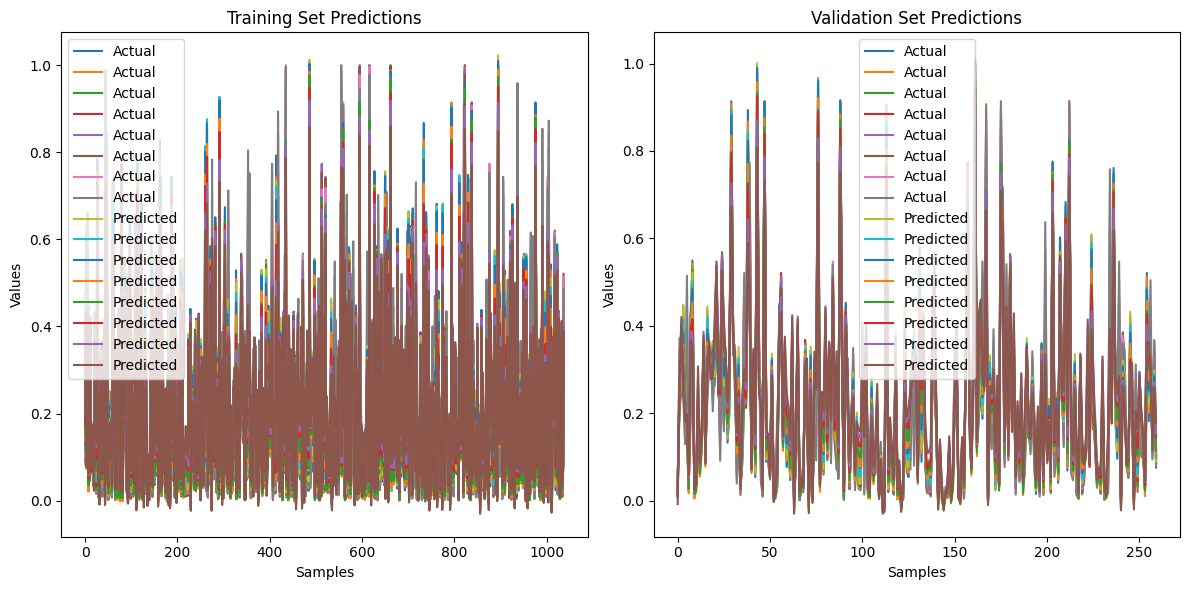

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import torch



# Evaluate the model
def evaluate_model(model, loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X, batch_y
            outputs = model(batch_X).squeeze()  # Generate predictions
            predictions.extend(outputs.numpy())
            targets.extend(batch_y.numpy())
    return np.array(predictions), np.array(targets)

# Load the best model for evaluation
model.load_state_dict(torch.load("best_transformer_model.pth"))



# Get predictions and targets for train and validation sets
train_predictions, train_targets = evaluate_model(model, train_loader)
val_predictions, val_targets = evaluate_model(model, val_loader)

# Calculate RMSE for train and validation sets
train_rmse = np.sqrt(mean_squared_error(train_targets, train_predictions))
val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

# Plotting Training vs Validation Predictions
plt.figure(figsize=(12, 6))

# Train predictions
plt.subplot(1, 2, 1)
plt.plot(train_targets, label="Actual")
plt.plot(train_predictions, label="Predicted")
plt.title("Training Set Predictions")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.legend()

# Validation predictions
plt.subplot(1, 2, 2)
plt.plot(val_targets, label="Actual")
plt.plot(val_predictions, label="Predicted")
plt.title("Validation Set Predictions")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.legend()

plt.tight_layout()
plt.show()




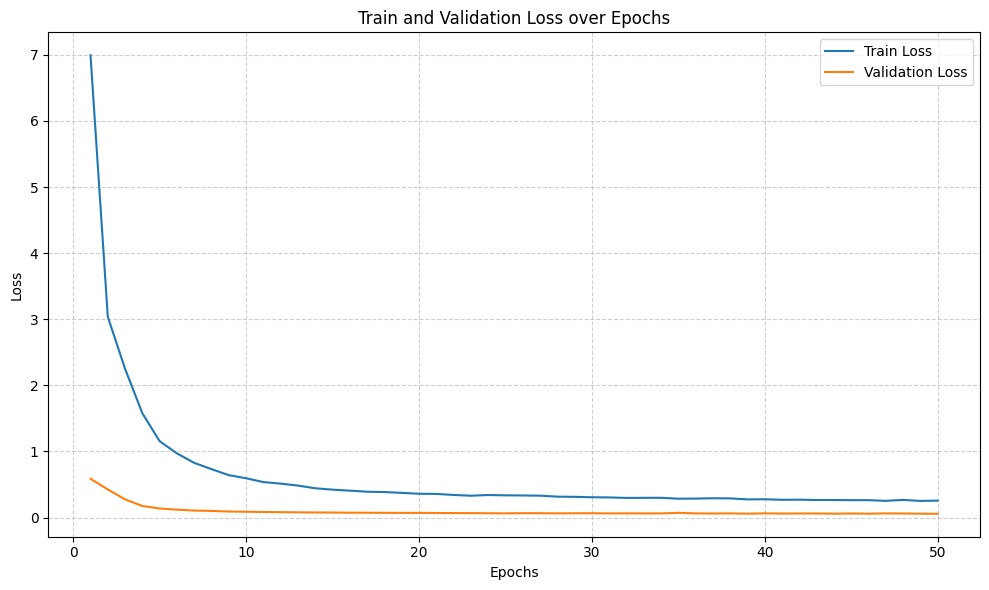

In [9]:
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_loss_history)+1), train_loss_history, '-', label='Train Loss')
plt.plot(range(1, len(val_loss_history)+1), val_loss_history, '-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


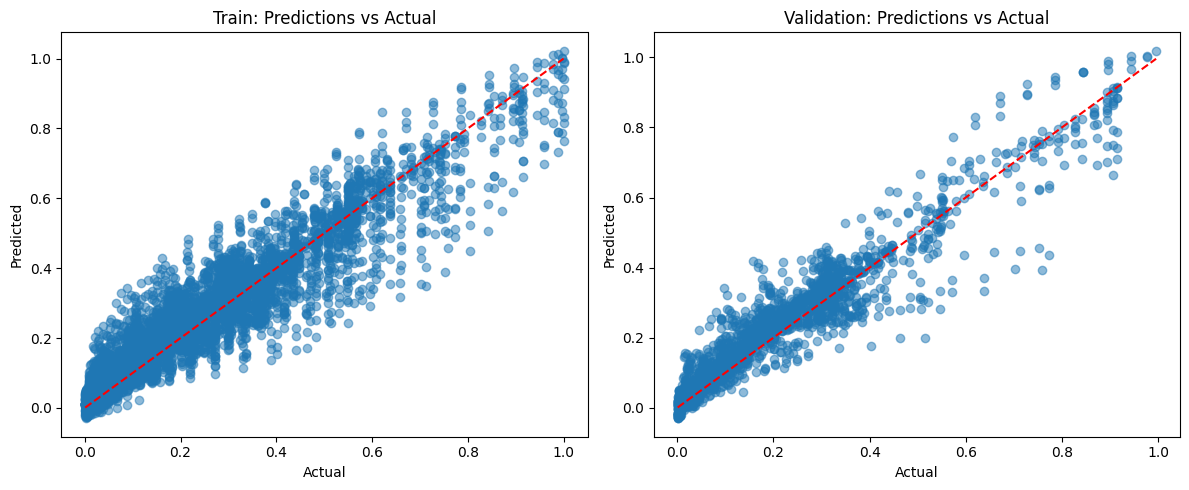

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(train_targets, train_predictions, alpha=0.5)
plt.plot([train_targets.min(), train_targets.max()],
         [train_targets.min(), train_targets.max()],
         'r--')
plt.title('Train: Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(1,2,2)
plt.scatter(val_targets, val_predictions, alpha=0.5)
plt.plot([val_targets.min(), val_targets.max()],
         [val_targets.min(), val_targets.max()],
         'r--')
plt.title('Validation: Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.show()


In [11]:
import numpy as np

# Assuming 'train_y' and 'train_prediction' are numpy arrays with shape (batch_size, sequence_length)

# Nash-Sutcliffe Efficiency (NSE) coefficient
nse_values = []
for i in range(train_y.shape[1]):  # Loop through each output sequence
    numerator = np.sum((train_y[:, i] - train_predictions[:, i]) ** 2)
    denominator = np.sum((train_y[:, i] - np.mean(train_y[:, i])) ** 2)
    nse = 1 - (numerator / denominator)
    nse_values.append(nse)
print("NSE:", nse_values)

# Evolution Criterion (Evol)
evol_values = []
for i in range(train_y.shape[1]):  # Loop through each output sequence
    numerator = np.sum(train_y[:, i])
    denominator = np.sum(train_predictions[:, i])
    evol = ((denominator - numerator) / numerator) * 100
    evol_values.append(evol)
print("Evol Criterion:", evol_values)

# Total Percent Error (TPE)
tpe_values = []
for i in range(train_y.shape[1]):  # Loop through each output sequence
    numerator = np.sum(np.abs(train_y[:, i] - train_predictions[:, i]))
    denominator = np.sum(train_y[:, i])
    tpe = numerator / denominator
    tpe_values.append(tpe)
print("TPE:", tpe_values)

NSE: [np.float64(0.9847707985350425), np.float64(0.9801547597714085), np.float64(0.9626987429995177), np.float64(0.9434569315881771), np.float64(0.9110574169016297), np.float64(0.8510824469631004), np.float64(0.8042951469355879), np.float64(0.749427257312482)]
Evol Criterion: [np.float64(8.77012569624843), np.float64(8.050886758411476), np.float64(9.03363818796227), np.float64(3.5175915628289505), np.float64(4.080714584324734), np.float64(8.884905736829152), np.float64(12.505369437306813), np.float64(10.421220315284357)]
TPE: [np.float64(0.09695648209847313), np.float64(0.10827562344347107), np.float64(0.14383622249508765), np.float64(0.16745845497079098), np.float64(0.20969780156872866), np.float64(0.2757223266506673), np.float64(0.32728465178469585), np.float64(0.36178330771114336)]


In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from numpy import array, hstack
from scipy.stats import pearsonr

# Prepare the test dataset
data_test = data.loc['2011-06-01':, :]

# Smoothing the data using Hamming window
for i in range(data_test.shape[1]):
    closes = data_test.iloc[:, i].values
    N = 20  # Blackman window size
    window = np.hamming(N)
    smoothed = np.convolve(window / window.sum(), closes, mode='same')
    data_test.iloc[:, i] = smoothed
# Normalizing the data with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_stacked_test = np.empty((len(data_test), 0))

for column in data_test.columns:
    x = data_test[column].values.reshape((-1, 1))  # Reshape for scaler
    x = scaler.fit_transform(x)  # Normalize
    dataset_stacked_test = hstack((dataset_stacked_test, x))  # Stack normalized columns

print("dataset_stacked_test.shape:", dataset_stacked_test.shape)

# Split the sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X_test, y_test = list(), list()
    for i in range(len(sequences) - n_steps_out):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        if out_end_ix > len(sequences) - n_steps_out:
            break
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix + 1, -1]
        X_test.append(seq_x)
        y_test.append(seq_y)
    return array(X_test), array(y_test)

# Example n_steps_in and n_steps_out values
n_steps_in = 30  # The number of previous time steps
n_steps_out =8 # The number of output time steps

X_test, y_test = split_sequences(dataset_stacked_test, n_steps_in, n_steps_out)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Device Configuration
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) on Apple Silicon.")
else:
    device = torch.device("cpu")
    print("Using CPU.")
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Make sure the model is also on the device
model.to(device)

# Predict on test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor).cpu().numpy()  # Detach predictions

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f"Test Score: {test_rmse:.4f} RMSE")

# Calculate metrics (as arrays for all timesteps in `n_steps_out`)
nse_values = []
rsr_values = []
evol_values = []
tpe_values = []
kge_value=[]

for step in range(n_steps_out):
    observed = y_test[:, step]
    predicted = test_predictions[:, step]

    # Nash-Sutcliffe Efficiency (NSE)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    nse = 1 - (numerator / denominator)
    nse_values.append(nse)

    # R-Squared Reliability (RSR)
    rsr = np.sqrt(numerator / denominator)
    rsr_values.append(rsr)

    # Evolution Criterion (Evol)
    evol = ((np.sum(predicted) - np.sum(observed)) / np.sum(observed)) * 100
    evol_values.append(evol)

    # Total Percent Error (TPE)
    numerator_tpe = np.sum(np.abs(observed - predicted))
    denominator_tpe = np.sum(observed)
    tpe = numerator_tpe / denominator_tpe
    tpe_values.append(tpe)

    #KGE
    # Compute components
    r, _ = pearsonr(predicted, observed)
    mean_simulated = np.mean(predicted)
    mean_observed = np.mean(observed)
    std_simulated = np.std(predicted)
    std_observed = np.std(observed)

    # Compute KGE
    kge = 1 - np.sqrt(
    (r - 1)**2 +
    ((std_simulated / std_observed) - 1)**2 +
    ((mean_simulated / mean_observed) - 1)**2
    )
    kge_value.append(kge)


# Print metrics for all timesteps
print("NSE Values:", np.round(nse_values, 4))
print("RSR Values:", np.round(rsr_values, 4))
print("Evol Values:", np.round(evol_values, 4))
print("TPE Values:", np.round(tpe_values, 4))
print("KGE Values:", np.round(kge_value, 4))

dataset_stacked_test.shape: (488, 2)
X_test.shape: (444, 30, 2)
y_test.shape: (444, 8)
Using CPU.
Test Score: 0.0840 RMSE
NSE Values: [0.9681 0.9495 0.913  0.8929 0.8337 0.7416 0.6366 0.5613]
RSR Values: [0.1786 0.2247 0.295  0.3272 0.4078 0.5084 0.6028 0.6624]
Evol Values: [14.3171 17.4145 21.6776 18.2802 22.6165 28.6451 36.1518 37.7336]
TPE Values: [0.1445 0.177  0.2297 0.2366 0.295  0.3753 0.4582 0.5028]
KGE Values: [0.843  0.8132 0.7681 0.8002 0.7533 0.6994 0.6204 0.596 ]


In [13]:
from scipy.signal import find_peaks
from scipy.stats import pearsonr
import numpy as np

# Assuming y_test and test_predictions are already defined
nse_values = []
rsr_values = []
evol_values = []
tpe_values = []
kge_value = []

for step in range(n_steps_out):
    observed = y_test[:, step]
    predicted = test_predictions[:, step]

    # Nash-Sutcliffe Efficiency (NSE)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    nse = 1 - (numerator / denominator)
    nse_values.append(nse)

    # R-Squared Reliability (RSR)
    rsr = np.sqrt(numerator / denominator)
    rsr_values.append(rsr)

    # Evolution Criterion (Evol)
    evol = ((np.sum(predicted) - np.sum(observed)) / np.sum(observed)) * 100
    evol_values.append(evol)

    # Modified Total Percent Error (TPE) using top 20% peaks
    peaks, _ = find_peaks(observed)
    peak_values = observed[peaks]
    num_top_peaks = max(1, int(0.2 * len(peak_values)))
    top_peak_indices = peaks[np.argsort(peak_values)[-num_top_peaks:]]
    observed_top = observed[top_peak_indices]
    predicted_top = predicted[top_peak_indices]
    numerator_tpe = np.sum(np.abs(observed_top - predicted_top))
    denominator_tpe = np.sum(observed_top)
    tpe = numerator_tpe / denominator_tpe
    tpe_values.append(tpe)

    # Kling-Gupta Efficiency (KGE)
    r, _ = pearsonr(predicted, observed)
    mean_simulated = np.mean(predicted)
    mean_observed = np.mean(observed)
    std_simulated = np.std(predicted)
    std_observed = np.std(observed)
    kge = 1 - np.sqrt(
        (r - 1)**2 +
        ((std_simulated / std_observed) - 1)**2 +
        ((mean_simulated / mean_observed) - 1)**2
    )
    kge_value.append(kge)
# Print metrics for all timesteps
print("NSE Values:", np.round(nse_values, 4))
print("RSR Values:", np.round(rsr_values, 4))
print("Evol Values:", np.round(evol_values, 4))
print("PE Values:", np.round(tpe_values, 4))
print("KGE Values:", np.round(kge_value, 4))

NSE Values: [0.9681 0.9495 0.913  0.8929 0.8337 0.7416 0.6366 0.5613]
RSR Values: [0.1786 0.2247 0.295  0.3272 0.4078 0.5084 0.6028 0.6624]
Evol Values: [14.3171 17.4145 21.6776 18.2802 22.6165 28.6451 36.1518 37.7336]
TPE Values: [0.074  0.0608 0.0566 0.0415 0.0414 0.1478 0.2063 0.3007]
KGE Values: [0.843  0.8132 0.7681 0.8002 0.7533 0.6994 0.6204 0.596 ]


In [14]:
import numpy as np
from scipy.signal import find_peaks

# Sample data
#observed = np.array([...])  # Replace with actual observed data
#predicted = np.array([...])  # Replace with actual predicted data
# Step 1: Find peaks
peaks, _ = find_peaks(observed)

# Step 2: Get peak values
peak_values = observed[peaks]

# Step 3: Select top 20% peaks
num_top_peaks = max(1, int(0.2 * len(peak_values)))
top_peak_indices = peaks[np.argsort(peak_values)[-num_top_peaks:]]

# Step 4: Filter observed and predicted
observed_top = observed[top_peak_indices]
predicted_top = predicted[top_peak_indices]

# Step 5: Calculate TPE
numerator_tpe = np.sum(np.abs(observed_top - predicted_top))
denominator_tpe = np.sum(observed_top)
tpe = numerator_tpe / denominator_tpe

# Append to list
tpe_values.append(tpe)


In [15]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Re-fit MinMaxScaler only on the target column (e.g., last column)
target_scaler = MinMaxScaler()
target_column = data_test.iloc[:, -1].values.reshape(-1, 1)
target_scaler.fit(target_column)

# Inverse transform the predictions
test_predictions_inverse_scale = target_scaler.inverse_transform(test_predictions)
print("Inverse-scaled predictions shape:", test_predictions_inverse_scale.shape)
print(test_predictions_inverse_scale)

Inverse-scaled predictions shape: (444, 8)
[[ 313.36383  366.41235  454.6665  ...  583.80383  631.96497  892.18494]
 [ 306.25903  362.0391   467.63318 ...  663.07794  717.488    984.5338 ]
 [ 301.41974  363.4866   488.64108 ...  752.9251   817.8306  1088.134  ]
 ...
 [3813.646   3435.7546  3366.4292  ... 2371.6353  2271.8271  2058.909  ]
 [3502.0667  3108.1682  3032.479   ... 2063.609   1981.6356  1790.1615 ]
 [3251.753   2853.5781  2768.8103  ... 1881.8528  1814.0237  1645.9556 ]]


In [16]:
y_test_inverse = target_scaler.inverse_transform(y_test)
print("Inverse-scaled predictions shape:", y_test_inverse.shape)

Inverse-scaled predictions shape: (444, 8)


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load raw actual future values (Day1)
df = pd.read_csv('rawtesty.csv')
actual_day1 = df.iloc[:, 0].values  # Day1 = column 0

# Step 2: Get inverse scaled y_test (actual past values used for comparison)
actual_y_test_day1 = y_test_inverse[:, 0]  # t+1 actuals from the test set

# Step 3: Compute offset
offset = actual_day1[:len(actual_y_test_day1)] - actual_y_test_day1

# Step 4: Add offset to predicted values
predicted_day1 = test_predictions_inverse_scale[:, 0]
predicted_day1_offset_corrected = predicted_day1 + offset

# Step 5: Plot actual vs offset-corrected predicted
min_len = min(len(actual_day1), len(predicted_day1_offset_corrected))
actual_trimmed = actual_day1[:min_len]
pred_trimmed = predicted_day1_offset_corrected[:min_len]
days = np.arange(1, min_len + 1)

plt.figure(figsize=(14, 6))
plt.plot(days, actual_trimmed, label='Day1 Actual (Raw)', linestyle='-', color='steelblue', linewidth=2)
plt.plot(days, pred_trimmed, label='Day1 Predicted + Offset', linestyle='-', color='darkorange', linewidth=2)

plt.xlabel('Days')
plt.ylabel('Inflow')
plt.title('Day1: Actual vs Offset-Corrected Predicted')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'rawtesty.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# prediction for next date
y_test_df = pd.DataFrame(y_test_inverse[:, 0], columns=['Actual'])
test_prediction_df = pd.DataFrame(test_predictions_inverse_scale[:, 0], columns=['Predicted'])

plt.figure(figsize=(14, 6))
plt.plot(y_test_df['Actual'], label='Actual', linestyle='-')
plt.plot(test_prediction_df['Predicted'], label='Predicted')

plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted values (t+1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("prediction_filtered shape:",test_predictions_inverse_scale.shape)